In [1]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#tqdm.pandas()
from time import time

In [4]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')


with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [4]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


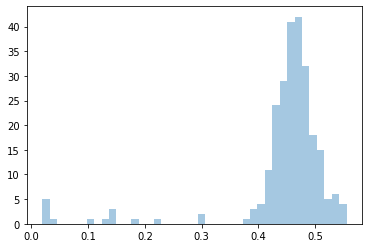

In [5]:
#standard deviations of embedding features
sns.distplot(np.std(embeddings,axis=0),kde=False)

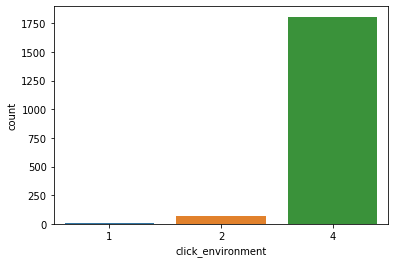

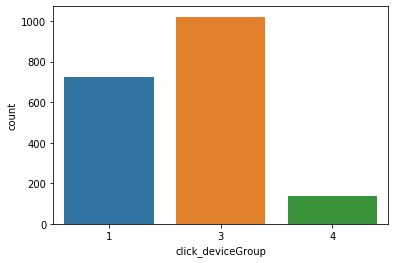

In [6]:
sns.countplot(clicks_sample.click_environment)
plt.show()
sns.countplot(clicks_sample.click_deviceGroup)
plt.show()

In [5]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id','click_environment','click_deviceGroup'] #validate with EDA
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [6]:
user_clicks = get_click_data()

In [7]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id,click_environment,click_deviceGroup
0,0,157541,4,3
1,0,68866,4,3
2,1,235840,4,1
3,1,96663,4,1
4,2,119592,4,1


user_id              322897
click_article_id      46033
click_environment         3
click_deviceGroup         5
dtype: int64

In [8]:
user_clicks.shape

(2951986, 4)

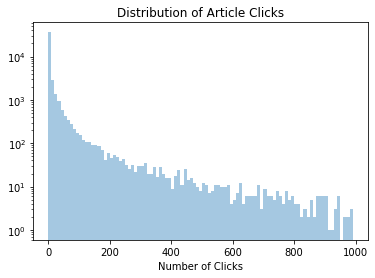

Min: 1
Max: 34245


In [10]:
sns.distplot(
    user_clicks.click_article_id.value_counts(),
    kde=False,
    bins=np.arange(0,1000,10)
).set_title('Distribution of Article Clicks')
plt.xlabel('Number of Clicks')
plt.yscale('log')
plt.show()

print('Min:', user_clicks.click_article_id.value_counts().min())
print('Max:', user_clicks.click_article_id.value_counts().max())

Article clicks are skewed heavily left.

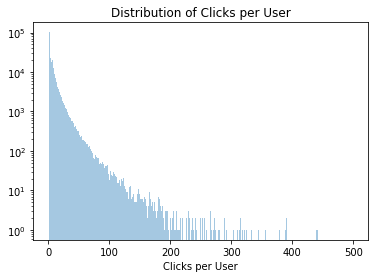

Min: 2
Max: 1048


In [13]:
sns.distplot(
    user_clicks.user_id.value_counts(),
    kde=False,
    bins = np.arange(0,500,1)
).set_title('Distribution of Clicks per User')
plt.xlabel('Clicks per User')
plt.yscale('log')
plt.show()

print('Min:', user_clicks.user_id.value_counts().min())
print('Max:', user_clicks.user_id.value_counts().max())

## To do
- figure out implicit rating system
- sample and train/test split
- models
    1. KNN
    2. Bucketed random projection (ANN)
        - https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/
        - https://eng.uber.com/lsh/
    3. User embeddings
    4. User embeddings with nonlinearity
        - use clustering to group interests


### User Embeddings
- Embeddings learned through SGNS maximize the dot-product between observed pairs and minimize it for random pairs.
- The dot product of embeddings of any given pair represents the likelihood of observing the pair together.
- If we are interested in learning an association between any two sets of entities, we can technically learn any kinds of embeddings through SGNS
- In our model, we will replace word pairs with reader - article pairs

In [16]:
#tools to use
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Data Setup
- Filter out irrelevant columns
- Pick users whomst'd've read at least N articles

In [20]:
df = user_clicks.copy()

In [ ]:
sizes = [df.user_id.nunique()]

for i in tqdm(range(2, 21)): #might be able to code this in a faster way
    sizes.append(df[df.groupby('user_id').user_id.transform(len) > i].user_id.nunique())

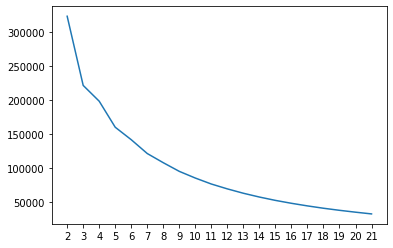

In [41]:
sns.lineplot(list(range(2,22)),sizes)
plt.xticks(range(2,22))
plt.show()

Might be a good idea to set N=10
Training set will have just 8 for each user, so there will be 2 or more to predict.

In [23]:
start = time()
df_ = df[df.groupby('user_id').user_id.transform(len) >= 10]
print(time()-start)

94.24544906616211


In [ ]:
df_['env_device'] = 'env:' + df_.click_environment.astype(str) + ' device:' + df_.click_deviceGroup.astype(str)
df_.drop(['click_environment','click_deviceGroup'],axis=1,inplace=True)

In [28]:
df_.head()

,user_id,click_article_id,env_device
2,1,235840,env:4 device:1
3,1,96663,env:4 device:1
6,3,236065,env:4 device:3
7,3,236294,env:4 device:3
10,5,168868,env:4 device:1


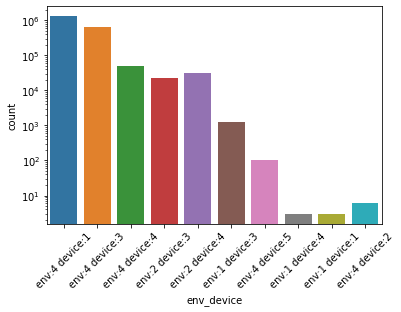

In [29]:
sns.countplot(df_.env_device)
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

#### Merge embeddings

In [241]:
df_ = df_.merge(
    pd.DataFrame(embeddings),
    how='left',
    left_on='click_article_id',
    right_index=True
)

10.697396039962769


In [244]:
df_.to_csv('data/user_embeddings.csv')

In [245]:
#read back
start = time()
df_ = pd.read_csv('data/user_embeddings.csv',index_col=0)
print(time()-start)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


99.77132892608643


In [246]:
df_.head()

,user_id,click_article_id,env_device,0,1,2,3,4,5,6,...,240,241,242,243,244,245,246,247,248,249
2,1,235840,env:4 device:1,-0.168369,-0.967274,0.226036,0.145089,-0.417114,-0.693828,-0.741834,...,-0.010313,-0.422416,0.372931,-0.540084,0.242361,0.616011,0.704936,0.571687,0.545211,0.650550
3,1,96663,env:4 device:1,-0.463952,-0.958577,-0.317925,0.143565,0.009962,0.510263,-0.703141,...,0.779381,0.505448,-0.262309,-0.442881,0.695514,0.748444,-0.209889,-0.231323,-0.082891,-0.203830
6,3,236065,env:4 device:3,-0.583720,-0.945301,-0.770678,-0.654855,-0.409393,-0.386152,-0.184850,...,-0.460681,-0.149449,0.158473,-0.431712,0.257235,-0.118843,-0.072126,-0.028298,0.327733,0.428365
7,3,236294,env:4 device:3,-0.791363,-0.967025,-0.247181,-0.462593,0.238766,-0.713218,-0.789062,...,-0.609091,0.230817,0.090354,-0.457567,-0.026513,-0.433131,0.347777,0.511057,0.470070,0.092472
10,5,168868,env:4 device:1,-0.566814,-0.969073,0.212298,-0.424613,-0.843768,0.529609,0.366083,...,0.023162,-0.634281,-0.334300,0.593486,-0.761024,0.364188,0.238170,0.681951,-0.501074,-0.115498


#### Split train and test

https://stackoverflow.com/questions/22472213/python-random-selection-per-group

In [247]:
start = time()
size = 8        # sample size per user
replace = False  # without replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df_train = df_.groupby('user_id', as_index=False).apply(fn)
print(time()-start)

126.30983185768127


In [248]:
#takes 17 minutes

start = time()
df_test = df_[~df_.index.isin(df_train.index)]
print(time()-start)

1037.9082367420197


In [250]:
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [252]:
#takes 19 minutes

start = time()
df_train.to_csv('data/train.csv')
df_test.to_csv('data/test.csv')
print(time()-start)

1147.8053047657013


# Load Train and Test Data

In [6]:
start = time()
df_train = pd.read_csv('data/train.csv',index_col=0)
df_test = pd.read_csv('data/test.csv',index_col=0)
print(time()-start)

120.73743486404419


In [4]:
print('train:', df_train.shape[0])
print('test:', df_test.shape[0])

train: 684502
test: 2029107


In [6]:
df_train.head()

,user_id,click_article_id,env_device,0,1,2,3,4,5,6,...,240,241,242,243,244,245,246,247,248,249
0,1,285719,env:4 device:1,-0.118549,-0.957376,-0.751805,-0.566605,-0.899491,-0.510777,0.510855,...,-0.274394,-0.054381,0.341704,-0.395201,0.378282,0.416298,-0.478623,0.912017,0.101685,0.660538
1,1,234481,env:4 device:1,-0.744894,-0.975940,-0.101474,-0.620068,0.516190,-0.695848,-0.850939,...,-0.327291,-0.009473,0.469663,-0.734911,-0.070421,-0.457637,0.518804,0.576141,0.763434,0.224886
2,1,235840,env:4 device:1,-0.168369,-0.967274,0.226036,0.145089,-0.417114,-0.693828,-0.741834,...,-0.010313,-0.422416,0.372931,-0.540084,0.242361,0.616011,0.704936,0.571687,0.545211,0.650550
3,1,283392,env:4 device:1,-0.248988,-0.976156,-0.069826,-0.692906,-0.695744,-0.703383,0.930634,...,0.224778,-0.870308,-0.753590,0.024811,0.536427,0.130145,-0.276387,0.464620,0.129086,0.382053
4,1,36162,env:4 device:1,0.394471,-0.954570,-0.126430,-0.031528,-0.202543,0.325258,-0.426356,...,0.121050,0.351851,-0.324864,-0.497410,0.602626,-0.189069,0.012937,0.401118,-0.050076,0.182424


# Model 1: User Latent Vectors

## 1b: Optimize User Embeddings with SGD

Note that simultaneous optimization of user and item embeddings, _U_ and _V_, with MapReduce is ideal for scalability, but is unnecessary since we're starting with document vectors already.

- Maximize Dot Product of User Embedding with Relevant Articles
- Minimize Dot Product of User Embedding with Random Articles

In [4]:
#actually not even necessary to have embeddings here. redundant for the way I'm doing it.
#use df_x for now and fix later
#also sample so it's fast
df_x = df_train[['user_id','click_article_id','env_device']].set_index(['user_id',df_train.index])[0:800]

NameError: name 'df_train' is not defined

In [8]:
df_x.to_csv('data/df_x.csv')

In [5]:
df_x = pd.read_csv('data/df_x.csv',index_col=0)

In [123]:
class LinearModel:
    def __init__(self, user_data, item_embeddings, size=8, embeddings_size=250, T=1):
        self.user_data = user_data
        self.item_embeddings = item_embeddings
        self.T = T
        self.Vd = LinearModel.d.get_embedding_vectors(
            item_embeddings, user_data, size, embeddings_size=embeddings_size
        )
        self.U = self.initialize_user_vectors(
            size=size,embeddings_size=embeddings_size
        )
        self.instantiate_errors()
        
    def initialize_user_vectors(self,size,embeddings_size=250):
        return np.mean(LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        ),axis=1) #.repeat(size,axis=0).reshape(-1,size,embeddings_size)
        
    def instantiate_errors(self):
        #this is for tracking in steps of SGD
        self.errors = []
    
    #############################
    ###### SEEN AND UNSEEN ######
    #############################
    
    class d:
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250):
            return np.hstack(V_embeddings[df.click_article_id.to_list()]).reshape(-1,size,embeddings_size)
    
    class dbar:
        @staticmethod
        def get_unseen(df, u, size, len_):
            return np.random.choice(
                np.delete(
                    np.arange(len_),
                    df[df.index.get_level_values(0)==u].click_article_id,
                ),
                size=size,
            )
        
        @staticmethod
        def get_all_unseen(df, size, len_=364047):            
            #semi-vectorized version
            return np.hstack(pd.DataFrame(
                df.index.get_level_values(0)
            ).drop_duplicates().user_id.map(
                lambda u: LinearModel.dbar.get_unseen(df, u, size, len_)
            ))
        
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250, len_=36047):
            return np.hstack(
                V_embeddings[LinearModel.dbar.get_all_unseen(df,size,len_=len_).tolist()]
            ).reshape(
                -1,
                size,
                embeddings_size
            )
    
    #########################
    ##### SGD UTILITIES #####
    #########################
    
    class gradient: 
        @staticmethod
        def J(U,Vd,Vdbar, size=8, embedding_size=250,hinge_param=1):

            
            
            # if it's less than zero, give zero
            # otherwise, 
#             return np.sum(
#                 np.multiply(
#                     hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0] > 0,
#                     np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
#                 )
#             )


            cost = hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
            return np.sum(
                np.max(
                    [np.zeros((U.shape[0],size)), cost], axis = 0
                )
            )
        
        @staticmethod
        def dJ(U,Vd,Vdbar,size=8,embedding_size=250,hinge_param=1):
            #conditional derivitive
            
            return np.sum(
                (
                    hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0]
                    - np.tensordot(U,Vd,axes=(1,2))[0] < 0
                ).repeat(
                    embedding_size
                ).reshape(-1,size,embedding_size) * (Vdbar - Vd),
                axis=1
            )
    
    ##### STOCHASTIC GRADIENT DESCENT ####

    
    #
    def SGD(self):
        #instantiate progress bar with tqdm
        #SGD_vectorized should be wrapped in here
        pass
    
    
    
    def SGD_vectorized(
        self,
        alpha=0.1,
        size=8,
        test_size=128,
        embeddings_size=250,
        test=True,
        hinge_param=1,
        iteration=0,
        max_iterations=500
    ):
        #Stochastic Gradient Descent

        #print('Vd', self.item_embeddings[0,0:10])
        
        #resample stuff
        Vdbar_small = LinearModel.dbar.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size,
        )

        self.U = self.U - alpha * LinearModel.gradient.dJ(
            self.U,
            self.Vd,
            Vdbar_small,
        ) #fix this
        
        
        while True:
            if test == True:
                Vdbar_big = LinearModel.dbar.get_embedding_vectors(
                    self.item_embeddings,
                    self.user_data,
                    test_size,
                    embeddings_size=embeddings_size,
                )
                
                J = LinearModel.gradient.J(
                    self.U,
                    self.Vd.repeat(test_size/size,axis=1),
                    Vdbar_big,
                    size=test_size,
                    embedding_size=250,
                    hinge_param=1
                )
                # the Vd reshape still needs to be fixed
                
                self.errors.append(J)
                
            if iteration == max_iterations:
                #stop iterating
                #display errors

                sns.lineplot(
                    x = range(len(self.errors)),
                    y = self.errors
                )
                return self.U
            #print(iteration)
            iteration += 1
            return self.SGD_vectorized(
                alpha=alpha, 
                size=size,
                test_size=test_size,
                embeddings_size=embeddings_size,
                test=test, 
                hinge_param=hinge_param,
                iteration=iteration, 
                max_iterations=max_iterations)

#### Test out Pipeline

In [121]:
np.max([np.zeros(3),[2,1,-1]],axis=0)

array([2., 1., 0.])

[-0.26824254 -0.9636772  -0.28512946 -0.32596728 -0.34310314 -0.2655414
 -0.25597954  0.02330121  0.22115023 -0.15524353]
[-0.28512904 -0.9619828  -0.5784541  -0.31468195 -0.81616414 -0.59818184
 -0.29224652  0.23229201  0.4908505  -0.3481715 ]


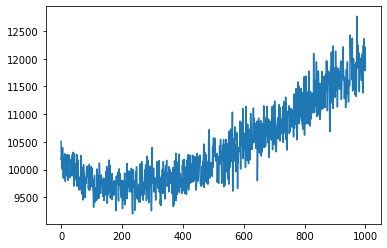

In [133]:
lm = LinearModel(df_x,embeddings,size=8, embeddings_size=250, T=1)
print(lm.U[0,0:10])
lm.SGD_vectorized(test=True,alpha=0.0001, max_iterations=1000, test_size=128)
print(lm.U[0,0:10])

In [88]:
np.zeros([2,12])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

#### Get the Vectors

In [51]:
model = LinearModel(df_x,embeddings,size=8,embeddings_size=250)

In [52]:
U = model.U
Vd = LinearModel.d.get_embedding_vectors(embeddings,df_x,size=8)
Vdbar = LinearModel.dbar.get_embedding_vectors(embeddings,df_x,size=8)

#### Linear Algebra Time

In [65]:
print(U.shape)
print(Vd.shape)
print(Vdbar.shape)

(100, 250)
(100, 8, 250)
(100, 8, 250)


In [29]:
#single user, single seen article, single unseen article
result = np.dot(U[0].T,Vdbar[0,0]) - np.dot(U[0].T,Vd[0,0])
result.shape
#dot product of two 1-d vectors is 0-dimensional

()

In [30]:
#single user, multiple articles, multiple unseen articles
result = np.tensordot(U,Vdbar[0],axes=(1,1))[0] - np.tensordot(U,Vd[0],axes=(1,1))[0]
result.shape
#dot product is one dimensional with a value for each article pair, 1-dimensional

(8,)

In [31]:
#many users, multiple articles per user
result = np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
result.shape
#dot tensor dot product is set of values for each user, 2-dimensional

(100, 8)

#### Test out Gradient Functions

In [64]:
LinearModel.gradient.J(U,Vd,Vdbar,hinge_param = 1)

ValueError: could not broadcast input array from shape (100,8) into shape (100)

In [35]:
LinearModel.gradient.dJ(U,Vd,Vdbar,hinge_param = 1)

array([[-2.1670804 ,  0.01750523,  0.6009317 , ..., -3.3537602 ,
         1.6586034 , -3.4772587 ],
       [ 3.7724528 ,  0.03113294,  1.7281439 , ..., -1.6146979 ,
        -0.1835354 , -0.6663277 ],
       [-1.5308888 , -0.01369971,  0.32890302, ..., -3.2731872 ,
         1.6275872 , -4.187475  ],
       ...,
       [ 0.88881075,  0.04453582,  1.6321135 , ...,  1.1757184 ,
        -1.6910233 , -0.1631453 ],
       [ 0.8616533 ,  0.02198362,  2.9430654 , ...,  0.08420932,
        -1.9836795 ,  0.38871142],
       [-0.21540785,  0.00680721,  1.034868  , ..., -4.025654  ,
         1.9805351 , -3.5346293 ]], dtype=float32)

#### Test out Pipeline

# Model 2: Multiple User Latent Vectors

### Part 0: Clustering The Corpus

In [11]:
def fit_kmeans(X,range_,ratio):
    distortions = []
    silhouettes = []
    for n_clusters in tqdm(range_):
        km = KMeans(
                n_clusters=n_clusters,
                init='k-means++',
                max_iter=300,
                algorithm='elkan',
                random_state=0,
            )
        
        sample = X[np.random.randint(
                    X.shape[0],
                    size=int(X.shape[0]*ratio)
                ), :]
        
        km.fit_predict(sample)
        
        distortions.append(
           km.inertia_
        )
        silhouettes.append(
            metrics.silhouette_score(sample, km.labels_)
        )
    #distortions
    plt.plot(range_, distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()
    #silhouettes
    plt.plot(range_, silhouettes, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    
def fit_hac(X,range_,ratio):
    for n_clusters in tqdm(range_):
        hac = AgglomerativeClustering(
            n_clusters=n_clusters,
            affinity='euclidean',
            linkage='single'
        ).fit(X)
        
        sample = X[np.random.randint(
                    X.shape[0],
                    size=int(X.shape[0]*ratio)
                ), :]
        
        hac.fit_predict(sample)

        plot_dendgrogram(hac)
    

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

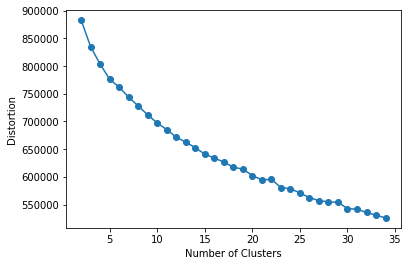

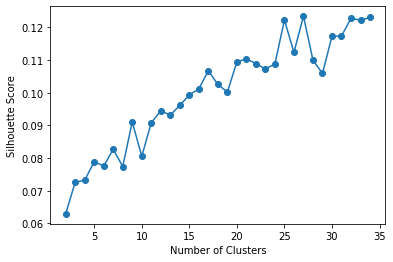

In [12]:
fit_kmeans(
    embeddings,
    range(2,35),
    0.05
)

#use elbow method to pick optimal number of clusters

### Part 1: User Interest Partition

In [ ]:
class 

### Part 2: Modeling

# Model 3: Nonlinear Latent Factorization with One-Pass Clustering
Article: https://www.researchgate.net/profile/Doreen_Cheng2/publication/266887747_Situation-aware_User_Interest_Mining_on_Mobile_Handheld_Devices/links/546e31b80cf2b5fc17606f8c.pdf

# Model 4: Hyperplane Separation

Generate User SVC weight matricies instead of embeddings

In [ ]:
# Tensorflow SVM Example:
import numpy
import tensorflow as tf

# X - (157, 128) - 157 sets of 128 features
# Y - (157) - classifications of the feature sets

X = numpy.zeros([157, 128])
Y = numpy.zeros([157], dtype=numpy.int32)
example_id = numpy.array(['%d' % i for i in range(len(Y))])

x_column_name = 'x'
example_id_column_name = 'example_id'

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X, example_id_column_name: example_id},
    y=Y,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=128),),
    l2_regularization=0.1)

svm.fit(input_fn=train_input_fn, steps=10)